<a href="https://www.kaggle.com/code/oscarm524/ps-s4-ep5-eda-modeling-submission?scriptVersionId=175350470" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook Versions

- Version 1 (04/30/2024)
    * EDA
    * Baseline modeling 1.0.
    
    
- Version 2 (05/01/2024)
    * Baseline modeling 1.0 updated.
    

- Version 3 (05/02/2024)
    * Baseline modeling 2.0 added.
    
# Loading Libraries

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, RidgeCV
from collections import Counter
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR, LinearSVR

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.neural_network import MLPRegressor

import optuna

# Reading Data Files

In [2]:
train = pd.read_csv('../input/playground-series-s4e5/train.csv')
test = pd.read_csv('../input/playground-series-s4e5/test.csv')
submission = pd.read_csv('../input/playground-series-s4e5/sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (1117957, 22)
The dimension of the test dataset is: (745305, 21)


In [3]:
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


In [4]:
test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,4,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,4,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,2,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,4,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,7,4,3,2,6,4,6,8,4,5,5


First, let's check for missing values in the `train` and `test` data frames.

In [5]:
train.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [6]:
test.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
dtype: int64

There are no missing values neither in the `train` or `test` data frames. Next, we check for duplicates.

In [7]:
print(f"There are {sum(train.drop(columns='id').duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the target columns, there are {sum(train.drop(columns=['id', 'FloodProbability']).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.drop(columns='id').duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the target columns, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


Finally, we check if there are any observations that appear in both the `train` and `test` data frames.

In [8]:
temp_train = train.drop(columns=['id', 'FloodProbability'], axis=1)
temp_test = test.drop(columns='id', axis=1)

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames")

There are 0 observations that appear in both the train and test data frames


# Data Exploration

First, we start by exploring the target feature.

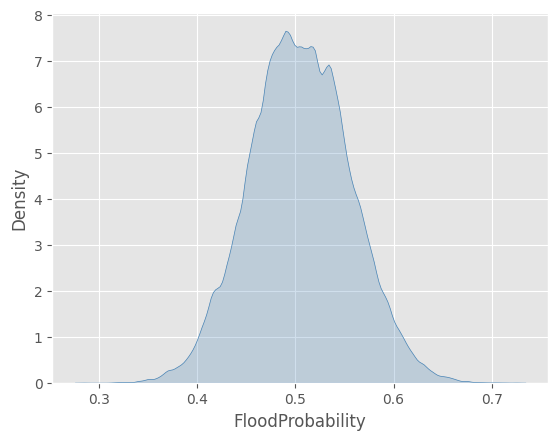

In [9]:
sns.kdeplot(data = train, x = 'FloodProbability', fill = True, color = 'steelblue');

From the above chart, we see that the distribution of `FloodProbability` is pretty symmetrical.

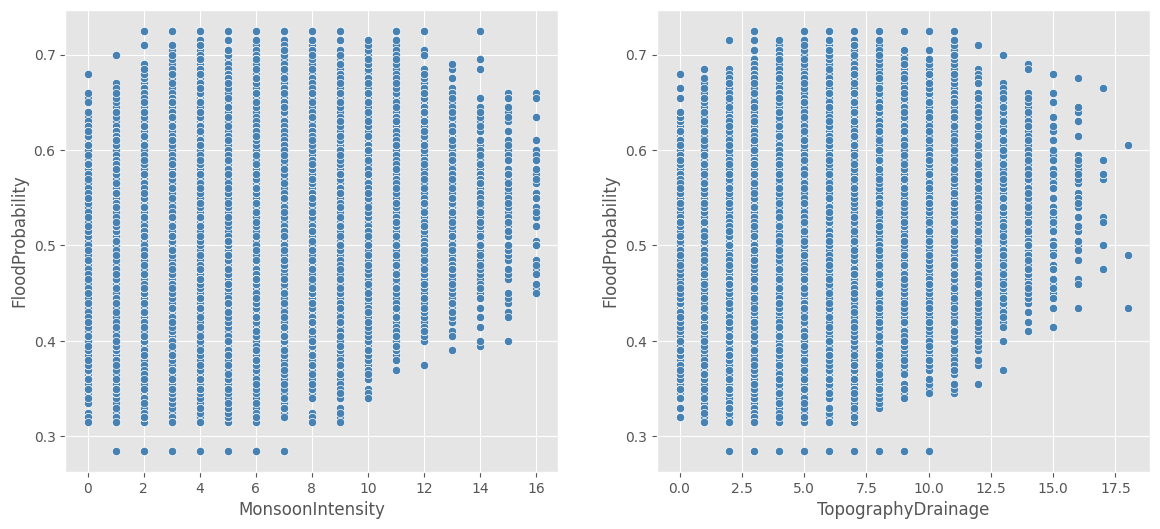

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (14, 6))
sns.scatterplot(ax=axes[0], data=train, x='MonsoonIntensity', y='FloodProbability', color='steelblue');
sns.scatterplot(ax=axes[1], data=train, x ='TopographyDrainage', y='FloodProbability', color='steelblue');

From the above, these are a couple of observations:

- It seems that as `MonsoonIntensity` increases, on average, the `FloodProbability` increases. In particular, when `MonsoonIntensity>=8`.
- It seems that as `TopographyDrainage` increases, on average, the `FloodProbability` increases. In particular, when `TopographyDrainage>=10`.

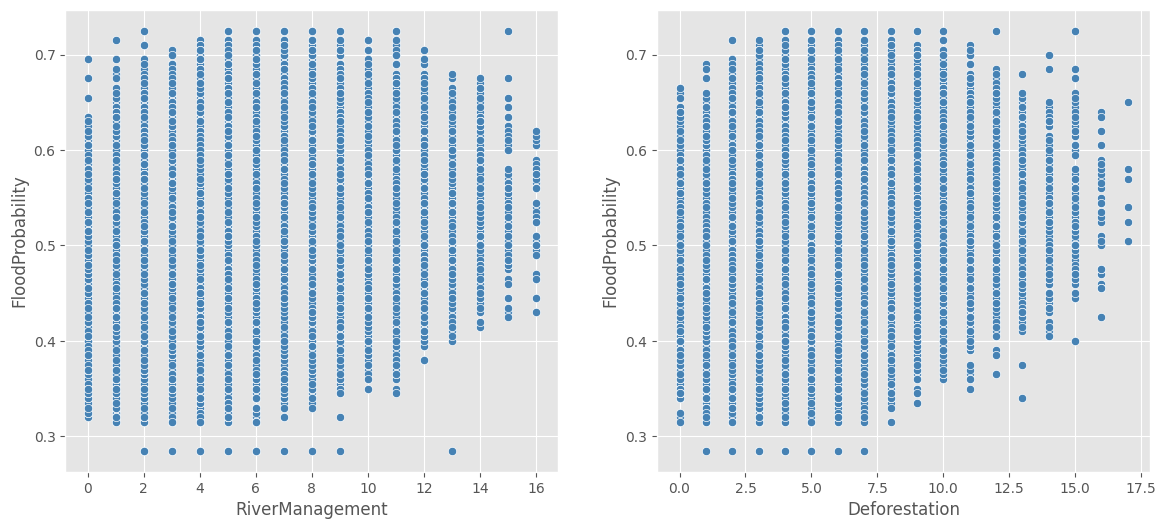

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (14, 6))
sns.scatterplot(ax=axes[0], data=train, x='RiverManagement', y='FloodProbability', color='steelblue');
sns.scatterplot(ax=axes[1], data=train, x ='Deforestation', y='FloodProbability', color='steelblue');

# Baseline Modeling 1.0

In this section, we train a few standard models with raw data. First, we define the input and target variables. 

In [12]:
X = train.drop(columns=['id', 'FloodProbability'], axis=1)
Y = train['FloodProbability']

skf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)

First, we start by training the `Ridge` model. Let's estimate `alpha` first as follows:

In [13]:
%%time
Ridge_alpha = RidgeCV(alphas=np.geomspace(0.001, 10, num=100).tolist(), cv=skf, scoring='r2').fit(X, Y)

print(f"The optimal value for alpha is {Ridge_alpha.alpha_}")
print(f"The 10-fold oof R2 score of the Ridge model is {Ridge_alpha.best_score_}")

The optimal value for alpha is 6.280291441834259
The 10-fold oof R2 score of the Ridge model is 0.8449429709949466
CPU times: user 8min, sys: 5min 33s, total: 13min 34s
Wall time: 6min 35s


Then, we re-train the `Ridge` model on the entire dataset to predict on the `test` dataset.

In [14]:
%%time
Ridge_md = Ridge(alpha = Ridge_alpha.alpha_, random_state=42).fit(X, Y)

test_cv = test.drop(columns=['id'], axis=1)
submission['FloodProbability'] = Ridge_md.predict(test_cv)
submission.head()

CPU times: user 473 ms, sys: 358 ms, total: 830 ms
Wall time: 410 ms


,id,FloodProbability
0,1117957,0.573615
1,1117958,0.455243
2,1117959,0.454742
3,1117960,0.466204
4,1117961,0.466068


In [15]:
submission.to_csv('baseline_sub_1.csv', index=False)

# Baseline Modeling 2.0

In this section, we use the `Ridge` model from the previous section to engineer a feature. 

In [16]:
%%time
train['Ridge_Pred'] = cross_val_predict(Ridge(alpha=6.28, random_state=42), train.drop(columns=['id', 'FloodProbability'], axis=1), train['FloodProbability'], cv=skf, n_jobs=-1)
Ridge_md = Ridge(alpha=6.28, random_state=42).fit(train.drop(columns=['id', 'FloodProbability', 'Ridge_Pred'], axis=1), train['FloodProbability'])

test['Ridge_Pred'] = Ridge_md.predict(test.drop(columns=['id'], axis=1))

CPU times: user 841 ms, sys: 673 ms, total: 1.51 s
Wall time: 4.91 s


Then, we engineer a couple of features as follows:

In [17]:
%%time
risk_factors = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'ClimateChange', 'DamsQuality', 'Siltation',  
                'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds',
                'DeterioratingInfrastructure', 'WetlandLoss', 'InadequatePlanning']

train['Avg_Risk'] = train[risk_factors].mean(axis=1)
train['Med_Risk'] = train[risk_factors].median(axis=1)
train['Q1_Risk'] = train[risk_factors].quantile(0.25, axis=1)
train['Q3_Risk'] = train[risk_factors].quantile(0.75, axis=1)
train['Std_Risk'] = train[risk_factors].std(axis=1)
train['Min_Risk'] = train[risk_factors].min(axis=1)
train['Max_Risk'] = train[risk_factors].max(axis=1)

test['Avg_Risk'] = test[risk_factors].mean(axis=1)
test['Med_Risk'] = test[risk_factors].median(axis=1)
test['Q1_Risk'] = test[risk_factors].quantile(0.25, axis=1)
test['Q3_Risk'] = test[risk_factors].quantile(0.75, axis=1)
test['Std_Risk'] = test[risk_factors].std(axis=1)
test['Min_Risk'] = test[risk_factors].min(axis=1)
test['Max_Risk'] = test[risk_factors].max(axis=1)

X = train.drop(columns=['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'ClimateChange', 'DamsQuality', 'Siltation',  
                'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds',
                'DeterioratingInfrastructure', 'WetlandLoss', 'InadequatePlanning', 'FloodProbability'], axis=1)
Y = train['FloodProbability']

test_cv = test.drop(columns=['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'ClimateChange', 'DamsQuality', 'Siltation',  
                'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds',
                'DeterioratingInfrastructure', 'WetlandLoss', 'InadequatePlanning'], axis=1)

CPU times: user 5.45 s, sys: 715 ms, total: 6.17 s
Wall time: 6.17 s


Finally, we train the `HistGradientBoostingRegressor` model on the entire dataset.

In [18]:
%%time
HGB_fit = HistGradientBoostingRegressor(**{'l2_regularization': 9.815981531893001,
                                           'early_stopping': False,
                                           'learning_rate': 0.09374135702599964,
                                           'max_iter': 938,
                                           'max_depth': 10,
                                           'max_bins': 254,
                                           'min_samples_leaf': 25,
                                           'max_leaf_nodes': 19,
                                           'random_state': 10}).fit(X, Y)

submission['FloodProbability'] = HGB_fit.predict(test_cv)
submission.head()

CPU times: user 3min 11s, sys: 519 ms, total: 3min 11s
Wall time: 49.2 s


,id,FloodProbability
0,1117957,0.577900
1,1117958,0.453936
2,1117959,0.450165
3,1117960,0.470123
4,1117961,0.465108


In [19]:
submission.to_csv('baseline_sub_2.csv', index=False)